# Project 22
Janne Kerola Y44019938

In [1]:
%load_ext jupyter_black
import nltk
from bs4 import BeautifulSoup
import requests

# 1 Webjaccard function

In [2]:
def get_results(query: str):
    cookies = {"CONSENT": "YES+cb.20220419-08-p0.cs+FX+111"}
    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/118.0"
    }
    baseurl = "https://www.google.com/search?q="
    url = baseurl + query
    response = requests.get(url, headers=headers, cookies=cookies)
    html = response.content
    soup = BeautifulSoup(html, "lxml")
    sent = soup.find(attrs={"id": "result-stats"})
    num = sent.text.split(" ")[1]
    num = num.replace("\xa0", "")
    return int(num)


def get_webjaccard(Q: str, P: str) -> float:
    """P&Q / ( P&Q + P&!Q + Q&!P)"""
    p_and_q = get_results(P + "+" + Q)
    p_not_q = get_results(P + "+" + "-" + Q)
    q_not_p = get_results(Q + "+" + "-" + P)
    return p_and_q / (p_and_q + p_not_q + q_not_p)

# 2 Science words

In [3]:
# Synonyms
p_list = "analysis workshop conclusion reaction review peer citation proof argument research topic plagiarism paraphrase equipment university department hypothesis theory labrat synthesis telegraph method design disagreement funding publish conference community recognition professor".split(
    " "
)
q_list = "experiment lab result counteraction audit associate quotation verification debate probe field infringement rehash machinery academy bureau premise concept subject fusion transmission approach composition antagonism backing announce symposium people respect educator".split(
    " "
)
syn_pairs = []
for i in range(0, 30):
    syn_pairs.append((p_list[i], q_list[i]))
synonyms = [get_webjaccard(n[0], n[1]) for n in syn_pairs]

In [4]:
# Antonyms
ant_words = "conclusion beginning reaction cause review neglect peer inferior citation demerit proof theory argument agreement research ignorance topic fact plagiarism originality paraphrase quotation department whole synthesis separation method disorganization design being publish conceal conference silence community dissimilarity recognition dishonor career recreation distinguish confuse verify invalidate invent destroy collaborate part educate learn question answer superhuman common genetic acquired disease health altered retained".split()
ant_pairs = []
for i in range(0, len(ant_words), 2):
    ant_pairs.append((ant_words[i], ant_words[i + 1]))
antonyms = [get_webjaccard(n[0], n[1]) for n in ant_pairs]

In [5]:
# Hypernyms
hyp_words = "astrology physics math archeology history pedagogy biology chemisty zoology medicine statistics metereology botany politics engineering psychology geography art geology business finance economics sociology anthropology agriculture computer logic earth applied social".split(
    " "
)
hyp_pairs = [("science", x) for x in hyp_words]
hypernyms = [get_webjaccard(n[0], n[1]) for n in hyp_pairs]

In [ ]:
%%script false --no-raise-error
# Save to data locally
with open("data/synonyms.txt", "w") as file:
    file.write(", ".join(f"{x[0], x[1]}" for x in syn_pairs))
    file.write("\n")
    file.write(", ".join(f"{x}" for x in synonyms))

with open("data/antonyms.txt", "w") as file:
    file.write(", ".join(f"{x[0], x[1]}" for x in ant_pairs))
    file.write("\n")
    file.write(", ".join(f"{x}" for x in antonyms))

with open("data/hypernyms.txt", "w") as file:
    file.write(", ".join(f"{x[0], x[1]}" for x in hyp_pairs))
    file.write("\n")
    file.write(", ".join(f"{x}" for x in hypernyms))

In [6]:
from statistics import stdev
from scipy.stats import kurtosis

# Calculating mean,stdev and kurtosis

items = [synonyms, antonyms, hypernyms]
means = [sum(x) / len(x) for x in items]
deviation = [stdev(x) for x in items]
kurtosis = [kurtosis(x) for x in items]
total = [sum(x) / len(x) for x in [means, deviation, kurtosis]]

In [7]:
from IPython.display import Markdown
import numpy as np

# Display results in a markdown table

magic = np.array([means, deviation, kurtosis]).T.tolist()
magic = [j for sub in magic for j in sub]
Markdown(
    """
|Dataset|Average|Std. deviation|Kurtosis|
|---|---|---|---|
|Synonyms|{:.4f}|{:.4f}|{:.4f}|
|Antonyms|{:.4f}|{:.4f}|{:.4f}|
|Hypernyms|{:.4f}|{:.4f}|{:.4f}|
|Total average|{:.4f}|{:.4f}|{:.4f}|
""".format(
        *magic, *total
    )
)


|Dataset|Average|Std. deviation|Kurtosis|
|---|---|---|---|
|Synonyms|0.0976|0.0852|-0.1652|
|Antonyms|0.0941|0.1303|1.8126|
|Hypernyms|0.1287|0.0956|-0.4578|
|Total average|0.1068|0.1037|0.3965|


# 3 Wordnet semantic similarity

In [8]:
from nltk.corpus import wordnet as wn
from nltk.corpus.reader.wordnet import WordNetError

# nltk.download("wordnet")

# Function definitions


def get_pair_similarity(pair: tuple):
    try:
        a = wn.synsets(pair[0])[0]
        b = wn.synsets(pair[1])[0]
        return a.wup_similarity(b)
    except IndexError:
        return 0


def get_path_similarity(pair: tuple):
    try:
        a = wn.synsets(pair[0])[0]
        b = wn.synsets(pair[1])[0]
        return a.path_similarity(b)
    except IndexError:
        return 0


def get_lch_similarity(pair: tuple):
    try:
        a = wn.synsets(pair[0])[0]
        b = wn.synsets(pair[1])[0]
        return a.lch_similarity(b, simulate_root=False)
    except IndexError:
        return 0
    except WordNetError:
        return 0

In [9]:
# Calculate similarities
pairs = [syn_pairs, ant_pairs, hyp_pairs]
wup = [get_pair_similarity(pair) for x in pairs for pair in x]
path = [get_path_similarity(pair) for x in pairs for pair in x]
lch = [get_lch_similarity(pair) for x in pairs for pair in x]
lch = [x for x in lch if x != None]

awup = sum(wup) / len(wup)
apath = sum(path) / len(path)
alch = sum(lch) / len(lch)

In [10]:
# Present in markdown table
Markdown(
    """
|Method|Average|
|---|---|
|WUP|{:.4f}|
|Path|{:.4f}|
|LCH|{:.4f}|
|webjaccard|{:.4f}|
""".format(
        awup, apath, alch, total[0]
    )
)


|Method|Average|
|---|---|
|WUP|0.4539|
|Path|0.1613|
|LCH|1.5045|
|webjaccard|0.1068|


# 4 Snippets

In [11]:
from requests_html import HTMLSession
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

# Using duckduckgo instead of google since it has longer snippets.
# Requires rendering results with javascript, therefore render with selenium!

opts = Options()
opts.add_argument("--headless")
driver = webdriver.Chrome(options=opts)


def get_snippets(query: str):
    baseurl = "https://www.duckduckgo.com/?q="
    url = baseurl + query
    driver.get(url)
    soup = BeautifulSoup(driver.page_source, "lxml")
    try:
        results = soup.find_all(attrs={"data-result": "snippet"})
        return [result.text for result in results]
    except Exception as e:
        print(e)
        return results


res = get_snippets("electrical_engineering")
print(res)

['Electrical engineering is an engineering discipline concerned with the study, design, and application of equipment, devices, and systems which use electricity, electronics, and electromagnetism.', 'Electrical engineering is an engineering field focused on electricity and electronics, from microscopic computer components to large power networks. Students who graduate with an electrical engineering majors will have job opportunities in wide-ranging fields, from telecommunications to the computer industry to the automotive industry.', 'Electrical engineers are inventors, designers and builders who understand how to manipulate currents and voltages in creative ways that advance technology. Like all areas of engineering, this...', 'Unit 1: Introduction to electrical engineering Getting started Unit 2: Circuit analysis Circuit elements Resistor circuits DC circuit analysis Natural and forced response AC circuit analysis Unit 3: Amplifiers Operational amplifier Unit 4: Semiconductor devices

# 5 Snippet similarity

In [12]:
import random

# Pick a random pair from all *nyms and get the first 10 snippets.

snippets = []
all_pairs = [*syn_pairs, *ant_pairs, *hyp_pairs]
pair = all_pairs[random.randint(0, len(all_pairs)) - 1]
_n5_pair = pair
p_snips = get_snippets(pair[0])
q_snips = get_snippets(pair[1])

In [13]:
# nltk.download("stopwords")
from nltk.corpus import stopwords
import re
import string

# Preprocessing steps

# Stopword removal
chars = "[" + re.escape(string.punctuation) + "]"

stops = stopwords.words("english")

q_sents = [snip.split(" ") for snip in q_snips]
p_sents = [snip.split(" ") for snip in p_snips]
q_filtered = []
for sent in q_sents:
    q_filtered.append(
        [re.sub(chars, "", word.lower()) for word in sent if not word.lower() in stops]
    )
p_filtered = []
for sent in p_sents:
    p_filtered.append(
        [re.sub(chars, "", word.lower()) for word in sent if not word.lower() in stops]
    )

# Stemming
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("english")
print(p_filtered)
p = []
q = []
for sent in p_filtered:
    p.append([stemmer.stem(word) for word in sent if word not in ["...", ""]])
for sent in q_filtered:
    q.append([stemmer.stem(word) for word in sent if word not in ["...", ""]])
print(p)

[['analysis', 'noun', 'detailed', 'examination', 'anything', 'complex', 'order', 'understand', 'nature', 'determine', 'essential', 'features', '', 'thorough', 'study', 'statement', 'examination'], ['analysis', 'pl', 'analyses', 'process', 'breaking', 'complex', 'topic', 'substance', 'smaller', 'parts', 'order', 'gain', 'better', 'understanding', 'it', 'technique', 'applied', 'study', 'mathematics', 'logic', 'since', 'aristotle', '384322', 'bc', 'though', 'analysis', 'formal', 'concept', 'relatively', 'recent', 'development'], ['analysis', 'definition', 'separating', 'material', 'abstract', 'entity', 'constituent', 'elements', 'opposed', 'synthesis', 'see', 'more'], ['analysis', 'meaning', '1', 'act', 'studying', 'examining', 'something', 'detail', 'order', 'discover', 'understand', 'more…', 'learn', 'more'], ['use', 'noun', 'analysis', 'refer', 'way', 'understand', 'something', 'looking', 'different', 'ways', 'studying', 'different', 'parts'], ['synonyms', 'analysis', 'investigation', 

In [14]:
# Calculating common, unique words requires flattening the snippets to 1d array
all_words = set([word for sent in q + p for word in sent])
q_words = set([word for sent in q for word in sent])
p_words = set([word for sent in p for word in sent])

common_words = set(
    [word for sent in q + p for word in sent if word in q_words and word in p_words]
)
ratio = len(common_words) / len(all_words)

In [15]:
# Present results in markdown table
Markdown(
    """
|Method|Average|
|---|---|
|WUP|{:.4f}|
|Path|{:.4f}|
|LCH|{:.4f}|
|webjaccard|{:.4f}|
|Sim_snippet1|{:.4f}|
""".format(
        awup, apath, alch, total[0], ratio
    )
)


|Method|Average|
|---|---|
|WUP|0.4539|
|Path|0.1613|
|LCH|1.5045|
|webjaccard|0.1068|
|Sim_snippet1|0.1012|


# 6.1 Opposing snippets - share %

In [16]:
# Get snippets for chosen query pairs
query_pairs = [
    ("minimalist living", "maximalist living"),
    ("open source software", "closed source software"),
    ("democratic regime", "authoritarian regime"),
]

results = []
for pair in query_pairs:
    a = get_snippets(pair[0])
    b = get_snippets(pair[1])
    results.append((a, b))
print(results)

[(["Minimalist Living Tips Overcome scarcity thinking Be in sync with others Know what you don't Eliminate clutter Indulge in simple pleasures Think like a stoic Create a realistic routine Develop a life philosophy Elevate your mindset Consider meditation alternatives Improve your relationship with money Streamline your personal style", "In other words, minimalist living would be a life-changing and life-giving realization. Unfortunately, for some, the idea of minimalism is just too counter-intuitive. It's an approach to life they have never been introduced to or have never been invited to explore. The benefits of minimalist living have never been articulated.", 'As such, minimalist living typically involves decluttering, organizing, and "minimizing" your home — all in order to lead a simpler, more purposeful lifestyle. Benefits of minimalist living: If...', "Minimalist living is a stress-free way of living when you simplify your life. Fewer belongings, more space, less quantity, and m

In [17]:
%%script false --no-raise-error
# Save snippets locally
for i in range(len(query_pairs)):
    with open(f"data/snippets_a{i}", "w") as file:
        content = "\n".join(results[i][0])
        file.write(content)
    with open(f"data/snippets_b{i}", "w") as file:
        content = "\n".join(results[i][1])
        file.write(content)

In [18]:
# Calculate how many 'shared' snippets exist between pairs
shared = []
for res in results:
    count = 0
    for snippet in res[0]:
        if snippet in res[1]:
            count += 1
    shared.append(count)
print(shared)

[0, 0, 0]


# 6.2 Opposing snippets - Similarity %

In [19]:
from thefuzz import fuzz

# Using token_set_ratio, as it ignores token order and common words. This should leave only the important words to compare!

fuzz_ratios = []
for pair in results:
    (a, b) = pair
    pair_ratios = []
    for snip_a in a:
        for snip_b in b:
            pair_ratios.append(fuzz.token_set_ratio(snip_a, snip_b))
    fuzz_ratios.append(pair_ratios)

avg_pair_ratios = [sum(ratios) / len(ratios) for ratios in fuzz_ratios]

In [20]:
# Present results in markdown table
magic = []
for i in range(len(fuzz_ratios)):
    magic.append(" vs. ".join(query_pairs[i]))
    magic.append(avg_pair_ratios[i])
Markdown(
    """
|Pair|Sim_snippet2|
|---|---:|
|{}|{:.2f}|
|{}|{:.2f}|
|{}|{:.2f}|
""".format(
        *magic
    )
)


|Pair|Sim_snippet2|
|---|---:|
|minimalist living vs. maximalist living|48.99|
|open source software vs. closed source software|55.26|
|democratic regime vs. authoritarian regime|48.98|


# 7 Sim_snip2 on syn-,ant-,hypernyms

In [21]:
# Calculate same as above for the randomly chosen pair in #5
prev_pair_ratios = []
for snip_a in a:
    for snip_b in b:
        prev_pair_ratios.append(fuzz.token_set_ratio(snip_a, snip_b))

n5_avg = sum(prev_pair_ratios) / len(prev_pair_ratios)

In [22]:
# Present markdown table
Markdown(
    """
|Pair|Sim_snippet2|
|---|---:|
|{}|{:.2f}|

""".format(
        " vs.".join(_n5_pair), n5_avg
    )
)


|Pair|Sim_snippet2|
|---|---:|
|analysis vs.experiment|48.98|



# 8 Pearson Correlation

In [70]:
from scipy.stats import pearsonr

# Manually comparing and giving snippets similarity values is hard, therefore limited to first 4 pairs in set 0.
human_eval = [2, 4, 2, 1, 0, 1, 3, 1, 5, 3, 3, 1, 0, 1, 0, 1]  # 0-10
(a, b) = results[0]
ss2 = []
ss1 = []
for x in a[:4]:
    for y in b[:4]:
        ss2.append(fuzz.token_set_ratio(x, y))

ss2_line, ss2_pval = pearsonr(human_eval, ss2)

In [134]:
# Tokenization
a_tokens = [sent.split(" ") for sent in a]
b_tokens = [sent.split(" ") for sent in b]

# stopword removal
a_stop = []
b_stop = []
for sent in a_tokens:
    a_stop.append(
        [re.sub(chars, "", word.lower()) for word in sent if not word.lower() in stops]
    )

for sent in b_tokens:
    b_stop.append(
        [re.sub(chars, "", word.lower()) for word in sent if not word.lower() in stops]
    )

# stemming
a_stem = []
b_stem = []
for sent in a_stop:
    a_stem.append([stemmer.stem(word) for word in sent if word not in ["...", ""]])

for sent in b_stop:
    b_stem.append([stemmer.stem(word) for word in sent if word not in ["...", ""]])

# Calculating the ratio
ss1_ratios = []
for n in a_stem[:4]:
    for m in b_stem[:4]:
        combined = set([word for word in n + m])
        common = set([word for word in n + m if word in set(n) and word in set(m)])
        ss1_ratios.append(len(common) / len(combined))

ss1_line, ss1_pval = pearsonr(human_eval, ss1_ratios)

In [102]:
# Present markdown table
Markdown(
    """
|Method|Line multiplier|p-value|
|---|---|---|
|Synsim1|{:.2f}|{:.2f}|
|Synsim2|{:.2f}|{:.2f}|

""".format(
        ss1_line, ss1_pval, ss2_line, ss2_pval
    )
)


|Method|Line multiplier|p-value|
|---|---|---|
|Synsim1|0.21|0.43|
|Synsim2|-0.02|0.96|



<BarContainer object of 16 artists>

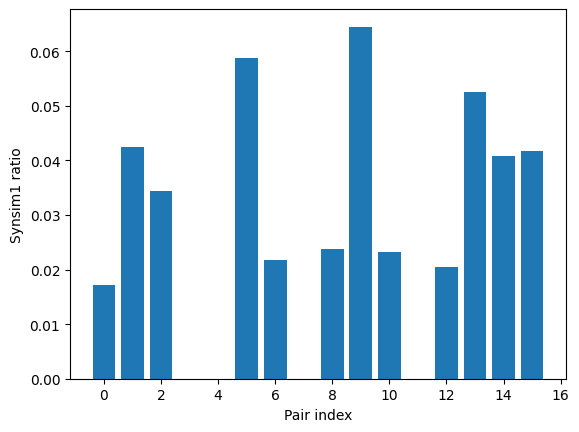

In [131]:
from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots()
plt.xlabel("Pair index")
plt.ylabel("Synsim1 ratio")
plt.bar([x for x in range(len(ss1_ratios))], ss1_ratios)

<BarContainer object of 16 artists>

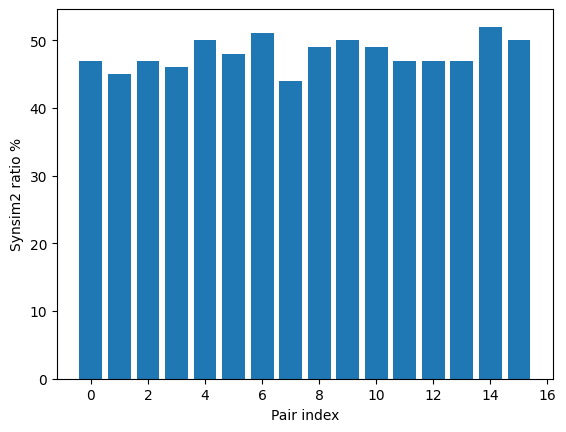

In [133]:
fig, ax = plt.subplots()
plt.xlabel("Pair index")
plt.ylabel("Synsim2 ratio %")
plt.bar([x for x in range(len(ss2))], ss2)